# Laboration 2: Optimalt sparande

Our lab is written in GO. To run it in notebook format please refer to https://github.com/gopherdata/gophernotes.

Babak Samimi & Kevin Kastberg

### Neccessary imports

In [203]:
import (
	"fmt"
	"image/color"
	"math"
	"bytes"
	"math/rand"

	"gonum.org/v1/gonum/mat"
	"gonum.org/v1/plot"
	"gonum.org/v1/plot/plotter"
	"gonum.org/v1/plot/vg"
)

### Helper functions

In [204]:
// Print a matrix in a nice format
func print_matrix(matrix *mat.Dense) {
	var rows, columns = matrix.Dims()
	fmt.Println("Matrix (", rows, "x", columns, "): ")
	for i := 0; i < rows; i++ {
		for j := 0; j < columns; j++ {
			fmt.Printf("%f ", matrix.At(i, j))
		}
		fmt.Println("")
	}
	fmt.Println("")
}

// Print a vector in a nice format
func print_vector(vector *mat.VecDense) {
	var rows, cols = vector.Dims()
	fmt.Println("Matrix (", rows, "x", cols, "): ")
	for i := 0; i < rows; i++ {
		fmt.Printf("%f ", vector.At(i, 0))
	}
	fmt.Println("")
}

// Function to plot the graphs of a list of functions given the x and y min and max
func plot_functions(x_min float64, x_max float64, y_min float64, y_max float64, functions []func(float64) float64, x_points [][]float64, y_points [][]float64) *plot.Plot {
	// Create a plot and set its title and axis label
	p, err := plot.New()
	if err != nil {
		panic(err)
	}
	p.Title.Text = "Graphs"
	p.X.Label.Text = "X"
	p.Y.Label.Text = "Y"
	p.X.Min = x_min
	p.X.Max = x_max
	p.Y.Min = y_min
	p.Y.Max = y_max

	// Create a grid
	grid := plotter.NewGrid()
	p.Add(grid)

	// Create a line of points
	for i := 0; i < len(functions); i++ {
		pts := make(plotter.XYs, 100)
		for j := 0; j < 100; j++ {
			x := x_min + (x_max-x_min)*float64(j)/100
			pts[j].X = x
			pts[j].Y = math.Max(math.Min(functions[i](x), y_max), y_min)
		}

		// Add the line to the plot
		l, err := plotter.NewLine(pts)
		if err != nil {
			panic(err)
		}
		l.LineStyle.Width = vg.Points(1)
		l.LineStyle.Color = color.RGBA{R: uint8(rand.Intn(255)), G: uint8(rand.Intn(255)), B: uint8(rand.Intn(255)), A: 255}
		p.Add(l)
	}

	// Create a scatter plot
	for i := 0; i < len(x_points); i++ {
		pts := make(plotter.XYs, len(x_points[i]))
		for j := 0; j < len(x_points[i]); j++ {
			pts[j].X = x_points[i][j]
			pts[j].Y = y_points[i][j]
		}

		// Add the line to the plot
		s, err := plotter.NewScatter(pts)
		if err != nil {
			panic(err)
		}
		s.GlyphStyle.Color = color.RGBA{R: uint8(rand.Intn(255)), G: uint8(rand.Intn(255)), B: uint8(rand.Intn(255)), A: 255}
		p.Add(s)
	}

	return p
}

// Create a plot given a list of lists of y values and a value t for the max x value
func plot_y_values(y_values [][]float64, t int) *plot.Plot {
	// Create a plot and set its title and axis label
	p, err := plot.New()
	if err != nil {
		panic(err)
	}
	p.Title.Text = "Graphs"
	p.X.Label.Text = "X"
	p.Y.Label.Text = "Y"

	// Create a grid
	grid := plotter.NewGrid()
	p.Add(grid)

	// Create a scatter plot
	for i := 0; i < len(y_values); i++ {
		pts := make(plotter.XYs, len(y_values[i]))
		for j := 0; j < len(y_values[i]); j++ {
			pts[j].X = float64(j) * (float64(t) / float64(len(y_values[i])))
			pts[j].Y = y_values[i][j]
		}

		// Add the line to the plot
		s, err := plotter.NewScatter(pts)
		if err != nil {
			panic(err)
		}
		s.GlyphStyle.Color = color.RGBA{R: uint8(rand.Intn(255)), G: uint8(rand.Intn(255)), B: uint8(rand.Intn(255)), A: 255}
		p.Add(s)
	}

	return p
}


// Display a plot in the notebook
func display_plot(p *plot.Plot) {
	var buf bytes.Buffer
	c, err := p.WriterTo(6*vg.Inch, 6*vg.Inch, "png")
	if err != nil {
			panic(err)
	}
	if _, err := c.WriteTo(&buf); err != nil {
			panic(err)
	}
	Display(display.PNG(buf.Bytes()))
}

// Calculate the rmse for a regression of a function given a list of x and y points and the function
func rmse(x_points []float64, y_points []float64, function func(float64) float64) float64 {
	var sum float64 = 0
	for i := 0; i < len(x_points); i++ {
		sum += math.Pow(y_points[i]-function(x_points[i]), 2)
	}
	return math.Sqrt(sum / float64(len(x_points)))
}

### Least squares method

$\vec{x} = (A^{T}A)^{-1}A^{T}\vec{b}$

In [205]:
// Solve a linear system of equations using least squares
// returns a list of the calculated constants ordered by the columns of A
func least_square(A *mat.Dense, b *mat.Dense) []float64 {
	A_rows, A_cols := A.Dims()
	_, b_cols := b.Dims()

	// Create the matrix (A^T*A)^-1
	A_T_A := mat.NewDense(A_cols, A_cols, nil)
	A_T_A.Mul(A.T(), A)
	A_T_A_inv := mat.NewDense(A_cols, A_cols, nil)
	A_T_A_inv.Inverse(A_T_A)

	// Create the matrix A^T*b
	A_T_b := mat.NewDense(A_cols, b_cols, nil)
	A_T_b.Mul(A.T(), b)

	// Calculate the solution x
	x := mat.NewDense(A_cols, b_cols, nil)
	x.Mul(A_T_A_inv, A_T_b)

	x_list := make([]float64, A_cols)
	for i := 0; i < A_cols; i++ {
		x_list[i] = x.At(i, 0)
	}

	return x_list
}

### Polynomial interpolation

In [206]:
// Perform polynomial interpolation to find the coefficients of the polynomial
func polynomial_interpolation(x []float64, y []float64) []float64 {
	point_count := len(x)
	y_vector := mat.NewVecDense(point_count, y)
	
	// Create vander matrix
	vander_matrix := mat.NewDense(point_count, point_count, nil)
	for row := 0; row < point_count; row++ {
		for col := 0; col < point_count; col++ {
			vander_matrix.Set(row, col, math.Pow(x[row], float64(col)))
		}
	}

	// Solve the system of equations
	var c mat.VecDense
	c.SolveVec(vander_matrix, y_vector)

	// Convert the solution to a list
	solution := make([]float64, point_count)
	for i := 0; i < point_count; i++ {
		solution[i] = c.At(i, 0)
	}
	return solution
}

## Problem 1

We want to minimize the following expression:

$\sum_{n=0}^{\infty} \frac{\tilde{U}\left(\tilde{\alpha}_n\right)}{f\left(X_n\right)-\tilde{\alpha}_n} \Delta X$

Where $α_{n}$ is the parameter we want to change for n=1,2,3…. This gives for each n the expression which we want to minimize: 

$\frac{\tilde{U}\left(\tilde{\alpha}_n\right)}{f\left(X_n\right)-\tilde{\alpha}_n} \Delta X$

Hence we know that if we found the minimal solution each of the expressions above (for each n) needs to fulfill:

$0=\frac{\partial}{\partial \tilde{\alpha}_n} \frac{\tilde{U}\left(\tilde{\alpha}_n\right)}{f\left(X_n\right)-\tilde{\alpha}_n}$

From this we can retrive the desired expression as:

$0=\frac{\partial}{\partial \tilde{\alpha}_n} \frac{\tilde{U}\left(\tilde{\alpha}_n\right)}{f\left(X_n\right)-\tilde{\alpha}_n}$

$0=\frac{(f(X_{n})-\tilde{\alpha}_n)\tilde{U}'\left(\tilde{\alpha}_n\right) + \tilde{U}\left(\tilde{\alpha}_n\right)}{(f\left(X_n\right)-\tilde{\alpha}_n)^{2}}$

$0=\frac{\tilde{U}'\left(\tilde{\alpha}_n\right)}{f\left(X_n\right)-\tilde{\alpha}_n} + \frac{\tilde{U}\left(\tilde{\alpha}_n\right)}{(f\left(X_n\right)-\tilde{\alpha}_n)^{2}}$

$1 = - \frac{\tilde{U}\left(\tilde{\alpha}_n\right)}{\tilde{U}'\left(\tilde{\alpha}_n\right)(f(X_{n})-\tilde{\alpha}_n)}$

$f(X_{n})-\tilde{\alpha}_n = \frac{\tilde{U}\left(\tilde{\alpha}_n\right)}{\tilde{U}'\left(\tilde{\alpha}_n\right)}$

$\square$

## Problem 2

We apply least of squares to fit a curve on the form 

$f(X_{n}) = aX+bX^{2}

to the data points provided. Then we can calculate the error with RMSE which is done below.

Then we use polynomial interpolation according to the method described in the lectures and implemented in the code below and above. According to theorem 3.4 (Sauer, 2011) the error for the polynomial interpolation in our case is 0.


Least squares solution:
a:  1.0708944034566272 b:  0.061849368625103374 RMSE:  0.13346578073852655

Polynomial interpolation solution:
Coefficients:  [0 -8.78166723647708 44.165113675259256 -70.92037448567002 51.97907708140844 -17.549630642626468 2.197481608106086] RMSE:  2.0158593113977334e-13


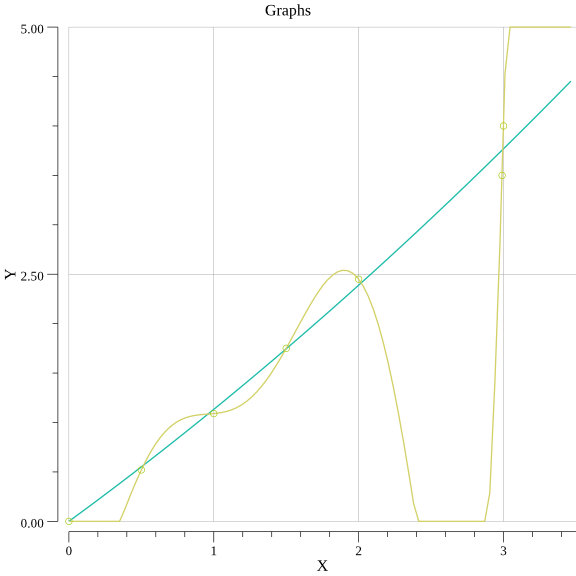

In [220]:
// Data points
x := []float64{0.0, 0.5, 1.0, 1.5, 2.0, 2.99, 3.0}
y := []float64{0.0, 0.52, 1.09, 1.75, 2.45, 3.5, 4.0}
data_count := len(x)

// Solve using least squares
A := mat.NewDense(data_count, 2, nil)
for i := 0; i < data_count; i++ {
	A.Set(i, 0, x[i])
	A.Set(i, 1, math.Pow(x[i], 2))
}
b := mat.NewDense(data_count, 1, y)

c1 := least_square(A, b)
a1 := c1[0]
b1 := c1[1]
func f1_1(x float64) float64 {return a1*x + b1*math.Pow(x, 2)};
e1 := rmse(x, y, f1_1)
fmt.Println("Least squares solution:")
fmt.Println("a: ", a1, "b: ", b1, "RMSE: ", e1)

// Solve using polynomial interpolation
c2 := polynomial_interpolation(x, y)
func f2(x float64) float64 {var y float64; for i := 0; i < len(c2); i++ {y = y + c2[i]*math.Pow(x, float64(i))}; return y};
e2 := rmse(x, y, f2)
fmt.Println("\nPolynomial interpolation solution:")
fmt.Println("Coefficients: ", c2, "RMSE: ", e2)

// Plot the results
p := plot_functions(0, 3.5, 0, 5, []func(float64) float64{f1_1, f2}, [][]float64{x}, [][]float64{y})
display_plot(p)

## Problem 3

In [208]:
// Data points
x := []float64{150, 200, 300, 500, 1000, 2000}
y := []float64{2, 3, 4, 5, 6, 7}
data_count := len(x)

Starting with equation (5)

$\frac{1}{U(x)} = \frac{1}{8} + \frac{a}{x}$

We rewrite is as this an use least of squares:

$\frac{1}{U(x)} - \frac{1}{8} = \frac{a}{x}$

In [209]:
// Solve using least squares
A := mat.NewDense(data_count, 1, nil)
for i := 0; i < data_count; i++ {
	A.Set(i, 0, 1/x[i])
}
b := mat.NewDense(data_count, 1, nil)
for i := 0; i < data_count; i++ {
	b.Set(i, 0, 1/y[i]-1.0/8.0)
}

c1 := least_square(A, b)
a1 := c1[0]
func f1(x float64) float64 {return 1.0/(1.0/8.0+a1/x)};
e1 := rmse(x, y, f1)
fmt.Println("Least squares solution:")
fmt.Println("a: ", a1, "RMSE: ", e1)

Least squares solution:
a:  48.46922258706006 RMSE:  0.3606392297954927


48 <nil>

Now equation (6)

$U(x) = 8 - ax^{b}$

Which we can rewrite as:

$ln(8-U(x)) = ln(a) - bln(x)$

In [210]:
// Solve using least squares
A := mat.NewDense(data_count, 2, nil)
for i := 0; i < data_count; i++ {
	A.Set(i, 0, 1)
	A.Set(i, 1, math.Log(x[i]))
}
b := mat.NewDense(data_count, 1, nil)
for i := 0; i < data_count; i++ {
	b.Set(i, 0, math.Log(8-y[i]))
}

c2 := least_square(A, b)
a2 := math.Exp(c2[0])
b2 := c2[1]
func f2(x float64) float64 {return 8 - a2*math.Pow(x, b2)};
e2 := rmse(x, y, f2)
fmt.Println("Least squares solution:")
fmt.Println("a: ", a2, "b: ", b2, "RMSE: ", e2)


Least squares solution:
a:  174.5246522317766 b:  -0.6640119820775112 RMSE:  0.18303941802090457


73 <nil>

Now we use GaussNewton on equation (6)

In [211]:
precision := 1e-99
max_iterations := 10000
a0 := 5.0
b0 := 0.1

func U(x float64, a float64, b float64) float64 {
	return 8 - a*math.Pow(x, b)
}

func J(x float64, a float64, b float64) (float64, float64) {
	return -math.Pow(x, b), -a*math.Log(x)*math.Pow(x, b)
}

// Iterate the gauss-newton algorithm
for n := 0; n < max_iterations; n++ {
	// Create the equation system Ax = b
	A := mat.NewDense(data_count, 2, nil)
	for i := 0; i < data_count; i++ {
		J0, J1 := J(x[i], a0, b0)
		A.Set(i, 0, J0)
		A.Set(i, 1, J1)
	}
	b := mat.NewDense(data_count, 1, nil)
	for i := 0; i < data_count; i++ {
		b.Set(i, 0, y[i] - U(x[i], a0, b0))
	}

	// Solve the equation system using least squares
	X := least_square(A, b)
	
	// Check if the solution is good enough
	X_mat := mat.NewDense(2, 1, X)
	if mat.Norm(X_mat, 1) < precision {
		break
	}

	// Refine the guesses
	a0 = a0 + X[0]
	b0 = b0 + X[1]
}

a3 = a0
b3 = b0
func f3(x float64) float64 {return U(x, a3, b3)};
e3 := rmse(x, y, f3)
fmt.Println("Gauus Newton solution:")
fmt.Println("a: ", a3, "b: ", b3, "RMSE: ", e3)

Gauus Newton solution:
a:  126.79319764502414 b:  -0.6082002220230581 RMSE:  0.12081020947745619


74 <nil>

In [212]:
// Solve using polynomial interpolation
c4 := polynomial_interpolation(x, y)
func f4(x float64) float64 {var y float64; for i := 0; i < len(c4); i++ {y = y + c4[i]*math.Pow(x, float64(i))}; return y};
e4 := rmse(x, y, f4)
fmt.Println("\nPolynomial interpolation solution:")
fmt.Println("Coefficients: ", c4, "RMSE: ", e4)


Polynomial interpolation solution:
Coefficients:  [-5.306571277159706 0.0803201037171653 -0.0002697683629007291 4.391615144556583e-07 -3.154038492273997e-10 7.699716523246483e-14] RMSE:  1.8586870976047228e-13


175 <nil>

Plot all the solutions

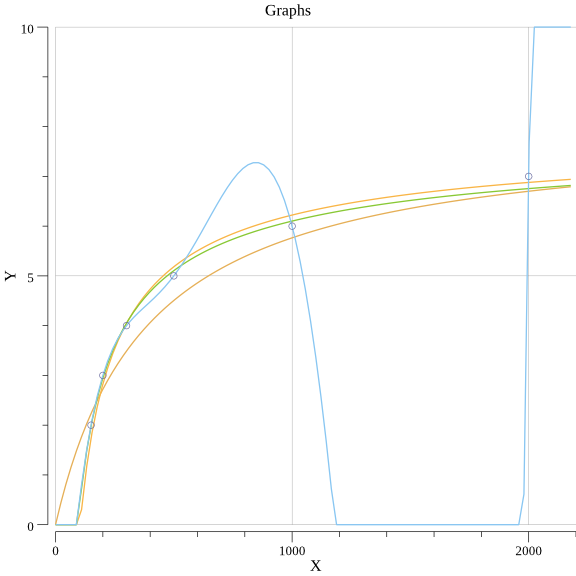

In [213]:
p := plot_functions(0, 2200, 0, 10, []func(float64) float64{f1, f2, f3, f4}, [][]float64{x}, [][]float64{y})
display_plot(p)

We can see that all four methods of regression gives a decent approxmate of the function U(x). One could say that polynomial interpolation is optimal since it gives no error but in this case we have U(inf)=8 which method 1-3 gives approximently while interpolation is very far from it.

Comparing the error we have for LS on (5) e1 = 0.36, for LS on (6) e2 = 0.18 and GN on (6) e3 = 0.12. So according to this metric which also seems vaild according to the graph the gauss-newton method would be to prefer.

## Problem 4

Broke at iteration:  7


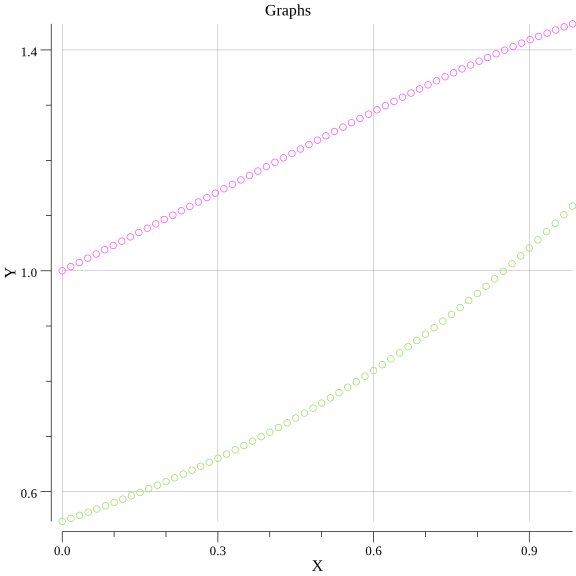

Broke at iteration:  8


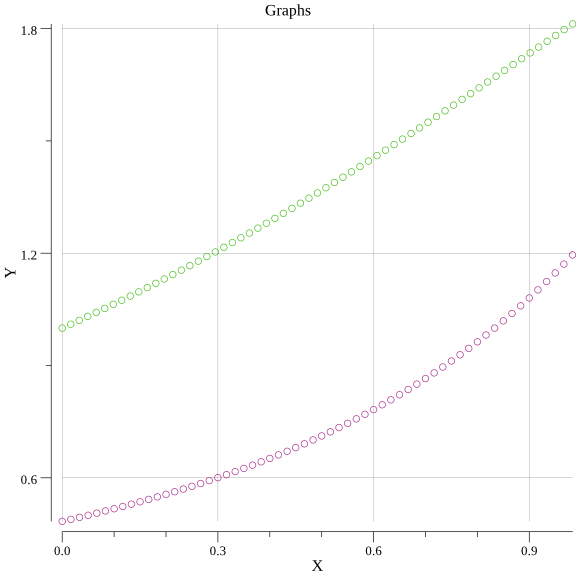

Broke at iteration:  8


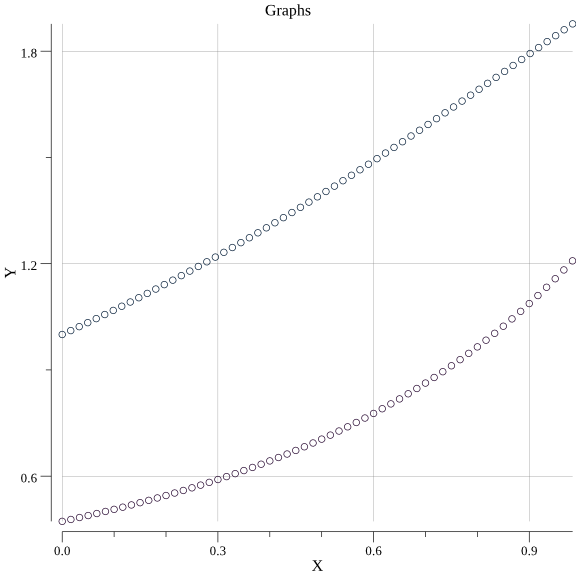

In [223]:
func g(x float64) float64 {
	return 2 * math.Sqrt(x)
}

// Derivative of g
func dg(x float64) float64 {
	return 1/math.Sqrt(x)
}

func p4_f1(X float64) float64 {
	return X
}

func p4_f2(X float64) float64 {
	return (X + (math.Pow(X, 2) / float64(10)))
}

func p4_f3(X float64) float64 {
	return f1_1(X)
}
	

func p4_solve_system(T int, N int, x0 int, f func(float64) float64) ([]float64, []float64) {

	dt := float64(T) / float64(N)
	max_iterations := 30
	precision := 1e-6

	X := mat.NewDense(N+1, 1, nil) // capital
	// Starting guesses for capital

	for i := 0; i < N+1; i++ {
		X.Set(i, 0, float64(x0))
	}
	
	// Store updates capital values
	X_updated := mat.NewDense(N+1, 1, nil)
	X_updated.Copy(X)

	// Changes in capital between iterations
	delta_X := mat.NewDense(max_iterations, 1, nil)

	lagrange_multiplicators := mat.NewDense(1, N, nil)

	for i := 0; i < max_iterations; i++ {

		// Initial value at t = 1
		lagrange_multiplicators.Set(0, N-1, dg(X.At(N, 0)))

		// Outer loop for lagrange multiplicator using backwards Euler
		for n := N-2; n >= 0; n-- {
			new_value := lagrange_multiplicators.At(0, n+1) + dt * f(X.At(n, 0)) * lagrange_multiplicators.At(0, n+1)
			lagrange_multiplicators.Set(0, n, new_value)
		}


		// Update capital value using forward Euler
		for n := 0; n < N; n++ {
			new_value := X_updated.At(n, 0) + dt * (f(X_updated.At(n, 0)) - (1 / math.Pow(lagrange_multiplicators.At(0, n), 3.0/5.0)))
			X_updated.Set(n+1, 0,  new_value)
		}

		// Subtract the capital X[i] with the updated capital, 
		// See if the change is small enough to break out of the outer loop
		delta_capital := mat.NewDense(N+1, 1, nil)
		delta_capital.Sub(X_updated, X)
		X.Copy(X_updated)

		if(mat.Norm(delta_capital, 2) < precision) {
			println("Broke at iteration: ", i)
			break
		}
	}

	// Calculate the consumption
	alpha := make([]float64, N)
	for i := 0; i < N; i++ {
		alpha[i] = math.Pow(lagrange_multiplicators.At(0, i), float64(-3) / float64(5))
	}

	return X.RawMatrix().Data, alpha

}

N := 60
t := 1
x0 := 1

a,b := p4_solve_system(t, N, x0, p4_f1)
p := plot_y_values([][]float64{a,b}, t)
display_plot(p)

a,b := p4_solve_system(t, N, x0, p4_f2)
p := plot_y_values([][]float64{a,b}, t)
display_plot(p)

a,b := p4_solve_system(t, N, x0, p4_f3)
p := plot_y_values([][]float64{a,b}, t)
display_plot(p)

## Problem 5

In problem 4 we calculate approximate values for the capital X and consumption alfa over a period of time. This is done with euler method which is a numerical method that does not give the exact solution and are neither certain to converge. However given that it converges which is the case for us it gives a good approximation. The error is proportional to the step size given by t/n.

However since we have no accurate description of f(X) this will induce further error.

Further we induce potential errors when making an initial guess of the capital unless it is accurate which is unlikely.